In [1]:
# Загружаем zip file
from google.colab import files
uploaded = files.upload()

import zipfile
import os

# Получаем доступ к сжатой папке и распаковывыаем ее чтобы получить доступ к изображениям
zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/corals_dataset')

# проверяем получившуюся структуру данных
os.listdir('/content/corals_dataset/corals')

Saving corals.zip to corals.zip


['bleached_corals', 'healthy_corals']

In [2]:
# Импортируем необходимые бибилиотеки
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report




# Задаем путь к датасету
dataset_dir = '/content/corals_dataset/corals'

In [3]:

import os

bleached_dir = os.path.join(dataset_dir, 'bleached_corals')
healthy_dir = os.path.join(dataset_dir, 'healthy_corals')

num_bleached = len(os.listdir(bleached_dir))
num_healthy = len(os.listdir(healthy_dir))

print(f"Number of bleached coral images: {num_bleached}")
print(f"Number of healthy coral images: {num_healthy}")


Number of bleached coral images: 485
Number of healthy coral images: 438


In [4]:
# Генерируем данные на основе фотографий в папке
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 739 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [15]:
# Загружаем предобученную модель ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False # Отавляем первые 30 словев нейросети замороженными

# Формируем итоговую модель
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), #Дропаут
    layers.Dense(1, activation='sigmoid')  # Бинарная классификация
])

# Компилируем модель
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Тренируем модель 50 эпох
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size + 1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size + 1,
    epochs=50
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6101 - loss: 0.6709 - val_accuracy: 0.7609 - val_loss: 0.5172
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.7951 - loss: 0.4626 - val_accuracy: 0.7772 - val_loss: 0.4992
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.8498 - loss: 0.3444 - val_accuracy: 0.7826 - val_loss: 0.6576
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 0.8792 - loss: 0.2912 - val_accuracy: 0.7935 - val_loss: 0.6192
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 486ms/step - accuracy: 0.9158 - loss: 0.2396 - val_accuracy: 0.7880 - val_loss: 0.7338
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - accuracy: 0.9185 - loss: 0.1998 - val_accuracy: 0.7880 - val_loss: 0.7368
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 0.9733 - loss: 0.1112 - val_accuracy: 0.7989 - val_loss: 0.9538
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 805ms/step - accuracy: 0.9357 - loss: 0.1462 - val_accurac

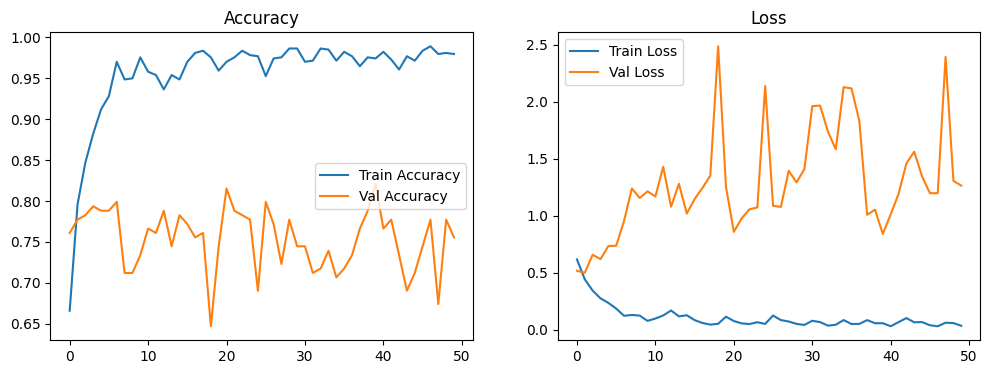

In [16]:
# График точности и лосса на трейне и валидации
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [17]:
# Выводим метрики на валидационном датасете
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Создаем матрпицу ошибок и отчет о классификации
Y_true = validation_generator.classes
Y_pred_prob = model.predict(validation_generator)
Y_pred = (Y_pred_prob > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=list(validation_generator.class_indices.keys())))

# Сохраняем модель
model.save('coral_resnet50_model.h5')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7038 - loss: 1.3840
Validation Accuracy: 75.54%
Validation Loss: 1.2639


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 854ms/step


Confusion Matrix:
[[61 36]
 [ 9 78]]

Classification Report:
                 precision    recall  f1-score   support

bleached_corals       0.87      0.63      0.73        97
 healthy_corals       0.68      0.90      0.78        87

       accuracy                           0.76       184
      macro avg       0.78      0.76      0.75       184
   weighted avg       0.78      0.76      0.75       184

